In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from skrebate import ReliefF
from sklearn.preprocessing import StandardScaler

In [2]:
# Charger les données
data = pd.read_csv('C:/Users/antho/Documents/MEMOIRE_M2/data_final.csv')

# Identifier les colonnes contenant des valeurs NA
na_columns = data.columns[data.isna().any()].tolist()

# Supprimer les colonnes avec des NA
data_cleaned = data.dropna(axis=1)

# Séparer les caractéristiques et les étiquettes
X = data_cleaned.drop('label', axis=1)  # données issues desc caractéristiques
y = data_cleaned['label'].apply(lambda X: 1 if X in ['fog', 'transitionFog'] else 0) # labels transofmré en cible et non cible



# Standardisation des caractéristiques

In [3]:

# Création d'un objet StandardScaler
scaler = StandardScaler()

# Adaptation du scaler aux données (calcul de la moyenne et de l'écart-type)
scaler.fit(X)  # X est votre DataFrame avec les caractéristiques

# Transformation des données de caractéristsiques
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)  
chemin_fichier_csv_datascaled = "C:/Users/antho/Documents/MEMOIRE_M2/data_final_scale.csv"




    # # # Exporter le DataFrame en tant que fichier CSV
X_scaled.to_csv(chemin_fichier_csv_datascaled, index=False)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42) # 30 des données sont gardés comme test

# VC pour créer des données FOG et enlever des données NOFOG avec SMOTE et Random

In [9]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler


# Préparation du pipeline
pipeline = Pipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('under_sampler', RandomUnderSampler(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))  # Remplacer par RandomForestClassifier() si nécessaire
])

# Grille de paramètres
param_grid = {
    'smote__sampling_strategy': np.linspace(0.1, 0.5, 5),
    'under_sampler__sampling_strategy': np.linspace(0.5, 0.9, 5)
}

# Variable pour collecter les résultats
results = []
errors = []

# Tester toutes les combinaisons de paramètres
for params in ParameterGrid(param_grid):
    pipeline.set_params(**params)
    try:
        pipeline.fit(X_train, y_train)
        score = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
        results.append((params, score))
    except Exception as e:
        errors.append((params, str(e)))

# Affichage des résultats valides
print("Valid combinations and their AUC scores:")
for res in results:
    print(res)

# Affichage des erreurs
if errors:
    print("\nCombinations that caused errors:")
    for err in errors:
        print(err)

# Choix et évaluation avec les meilleurs paramètres
if results:
    best_params, best_score = max(results, key=lambda x: x[1])
    print("\nBest parameters found:", best_params)
    print("Best AUC score:", best_score)
    # Configurer le pipeline avec les meilleurs paramètres pour évaluation finale
    pipeline.set_params(**best_params)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))
else:
    print("No valid parameter combinations were found.")


Valid combinations and their AUC scores:
({'smote__sampling_strategy': 0.2, 'under_sampler__sampling_strategy': 0.5}, 0.9871794871794871)
({'smote__sampling_strategy': 0.2, 'under_sampler__sampling_strategy': 0.6}, 0.9935897435897436)
({'smote__sampling_strategy': 0.2, 'under_sampler__sampling_strategy': 0.7}, 0.9935897435897436)
({'smote__sampling_strategy': 0.2, 'under_sampler__sampling_strategy': 0.8}, 0.9935897435897436)
({'smote__sampling_strategy': 0.2, 'under_sampler__sampling_strategy': 0.9}, 0.9935897435897436)
({'smote__sampling_strategy': 0.30000000000000004, 'under_sampler__sampling_strategy': 0.5}, 1.0)
({'smote__sampling_strategy': 0.30000000000000004, 'under_sampler__sampling_strategy': 0.6}, 1.0)
({'smote__sampling_strategy': 0.30000000000000004, 'under_sampler__sampling_strategy': 0.7}, 0.9871794871794871)
({'smote__sampling_strategy': 0.30000000000000004, 'under_sampler__sampling_strategy': 0.8}, 0.9871794871794871)
({'smote__sampling_strategy': 0.30000000000000004, '

In [10]:
# Si des résultats valides ont été collectés
if results:
    # Trouver la combinaison de paramètres avec le meilleur score AUC
    best_params, best_score = max(results, key=lambda x: x[1])
    print("\nBest parameters found:", best_params)
    print("Best AUC score:", best_score)

    # Configurer le pipeline avec les meilleurs paramètres
    pipeline.set_params(**best_params)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)

    # Évaluer et afficher le rapport de classification pour les meilleurs paramètres
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))
else:
    print("No valid parameter combinations were found.")



Best parameters found: {'smote__sampling_strategy': 0.30000000000000004, 'under_sampler__sampling_strategy': 0.5}
Best AUC score: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      0.75      0.86         4

    accuracy                           0.98        43
   macro avg       0.99      0.88      0.92        43
weighted avg       0.98      0.98      0.98        43



# Ajout des données FOG et Suppression des données NOFOG grâce à SMOTE combinés avec RandomUnderSampler

In [11]:
''' Ce code est faux, car il désorgansier tous les index appropriés à la nature des classes. Ainsi
les données de fenêtres n'appartiennent pas forcément aux classe définit dans y_train'''

# from imblearn.pipeline import Pipeline

# # Ajout de l'index comme colonne dans X_train
# X_train['original_index'] = X_train.index


# Extraction des meilleurs paramètres
# best_params = GridSearchCV.best_params_
best_smote_strategy = best_params['smote__sampling_strategy']
best_under_strategy = best_params['under_sampler__sampling_strategy']

# Configuration du pipeline final avec les paramètres optimaux
final_pipeline = Pipeline([
    ('smote', BorderlineSMOTE(sampling_strategy=best_smote_strategy, random_state=42)),
    ('under_sampler', RandomUnderSampler(sampling_strategy=best_under_strategy, random_state=42))
])

# Application du pipeline sur les données d'entraînement
X_resampled, y_resampled = final_pipeline.fit_resample(X_train, y_train)

# Affichage des nouvelles distributions des classes
print("Distribution des classes avant le pipeline:", pd.Series(y_train).value_counts())
print("Nouvelle distribution des classes après le pipeline:", pd.Series(y_resampled).value_counts())


Distribution des classes avant le pipeline: 0    83
1    15
Name: label, dtype: int64
Nouvelle distribution des classes après le pipeline: 0    48
1    24
Name: label, dtype: int64


# Visualisation pour voir si les données ajoutées modifie les données

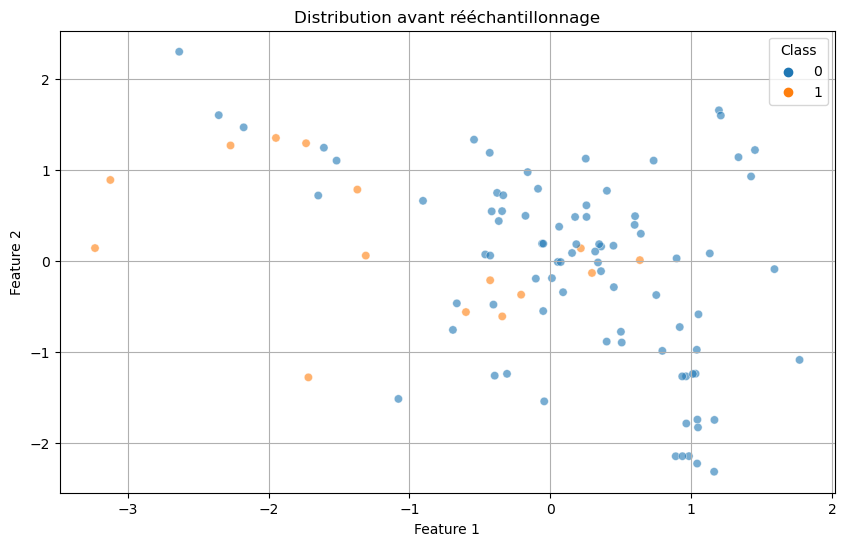

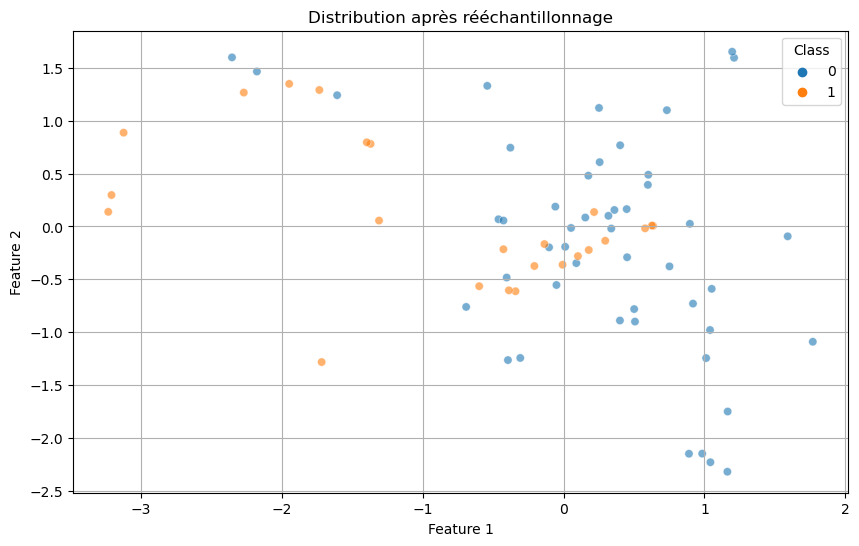

In [8]:
# Fonction pour créer un nuage de points
import matplotlib.pyplot as plt
import seaborn as sns

def plot_data(X, y, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, alpha=0.6)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(title='Class')
    plt.grid(True)
    plt.show()
    
# Choisissez les deux premières caractéristiques pour la visualisation si vous avez plus de deux dimensions
plot_data(X_train.iloc[:, :2].values, y_train, "Distribution avant rééchantillonnage")
plot_data(X_resampled.iloc[:, :2].values, y_resampled, "Distribution après rééchantillonnage")

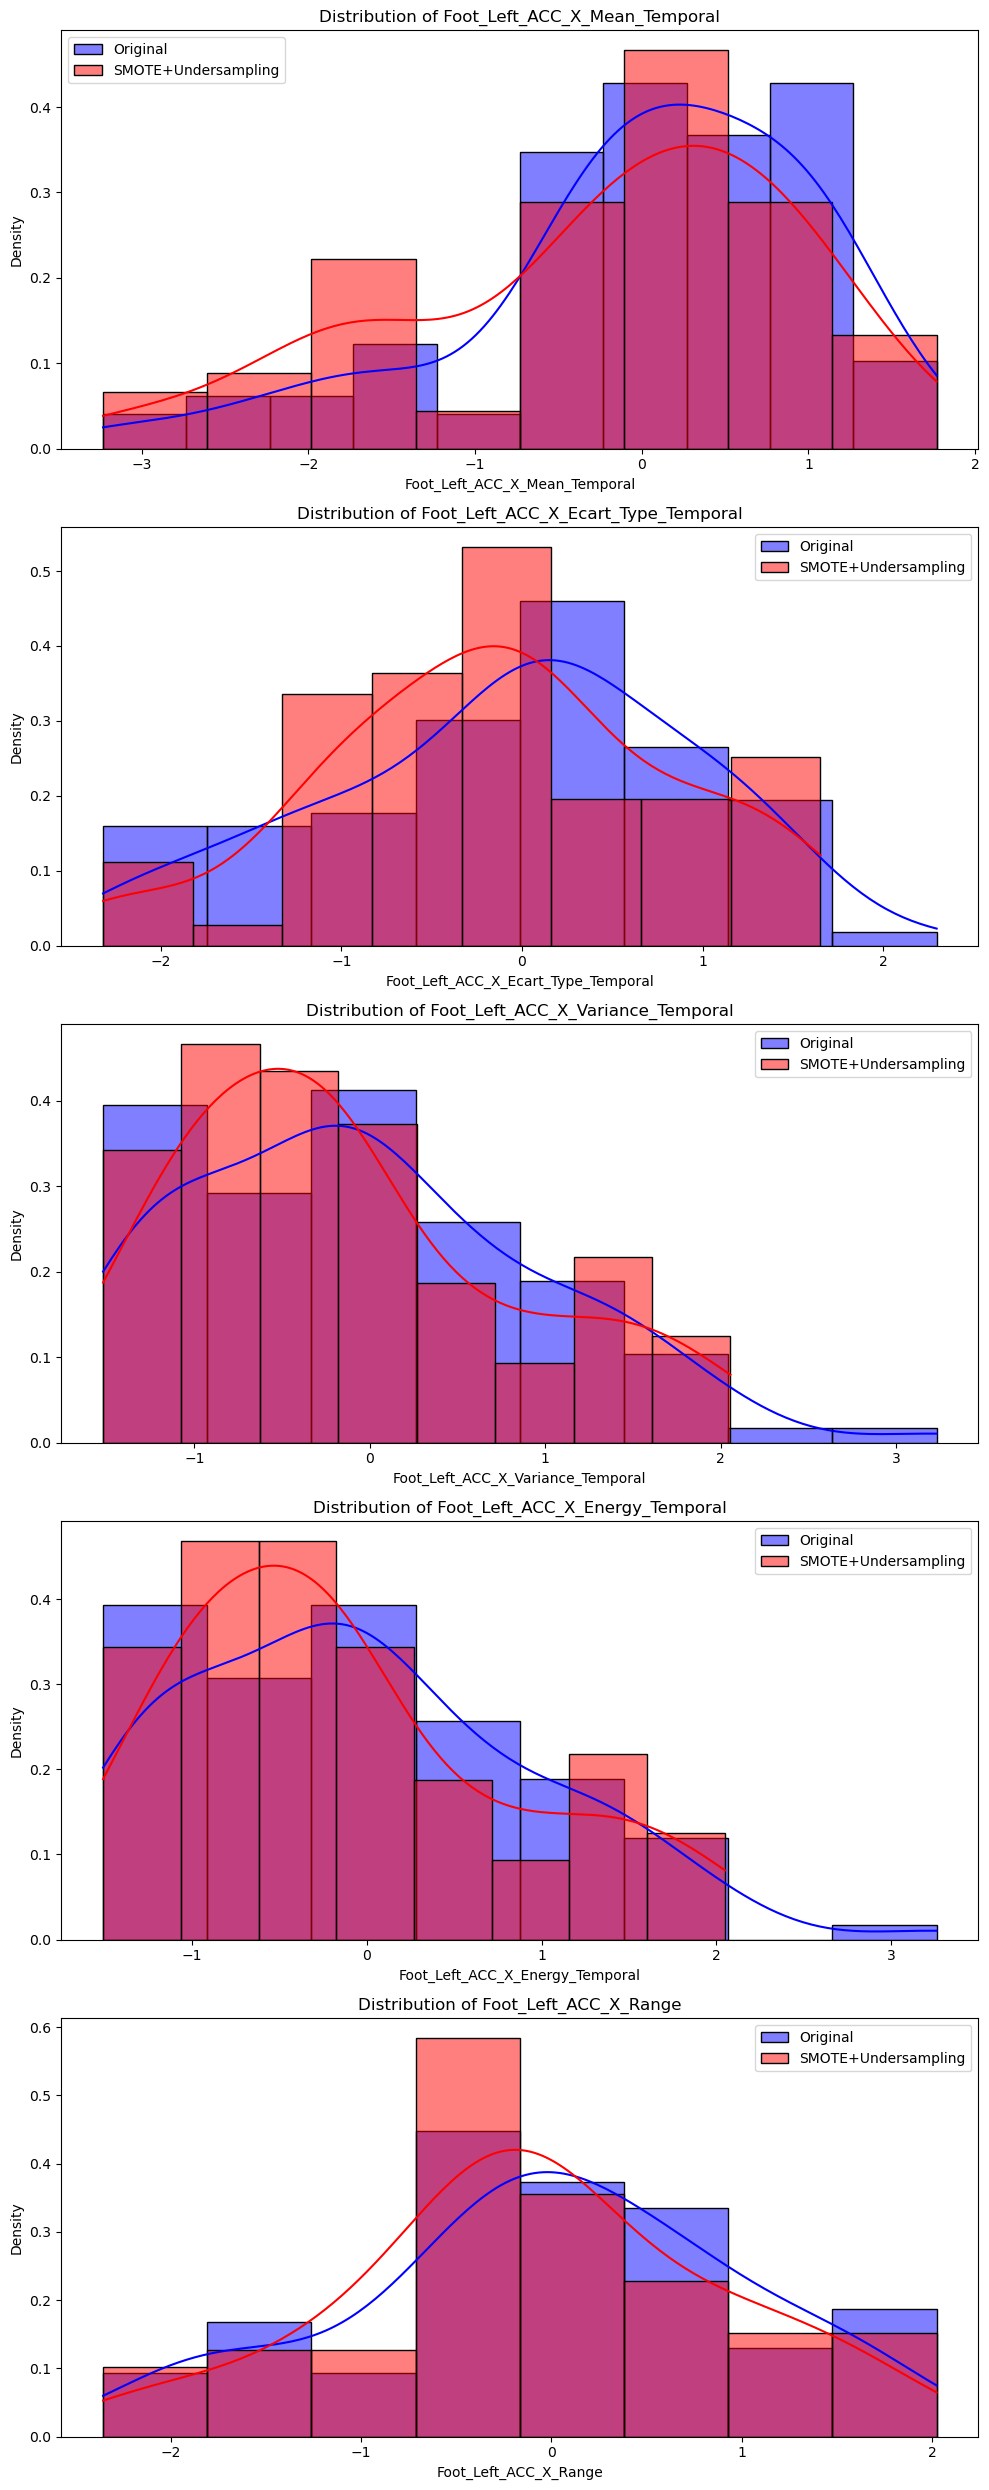

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélection des 10 premières caractéristiques de X_train (ajustez si nécessaire pour votre DataFrame)
features_to_plot = X_train.columns[:5]  # Modifiez selon le nombre réel de colonnes si nécessaire

# Fonction pour tracer les distributions des caractéristiques
def plot_feature_distributions(df1, df2, feature_names, df1_label='Original', df2_label='SMOTE+Undersampling'):
    fig, axes = plt.subplots(nrows=len(feature_names), ncols=1, figsize=(10, 5 * len(feature_names)))
    for i, feature in enumerate(feature_names):
        ax = axes[i] if len(feature_names) > 1 else axes
        sns.histplot(df1[feature], color="blue", label=df1_label, kde=True, ax=ax, stat="density", common_norm=False)
        sns.histplot(df2[feature], color="red", label=df2_label, kde=True, ax=ax, stat="density", common_norm=False)
        ax.set_title(f'Distribution of {feature}')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Appel de la fonction pour tracer les distributions des 10 premières caractéristiques
plot_feature_distributions(X_train, X_resampled, features_to_plot)


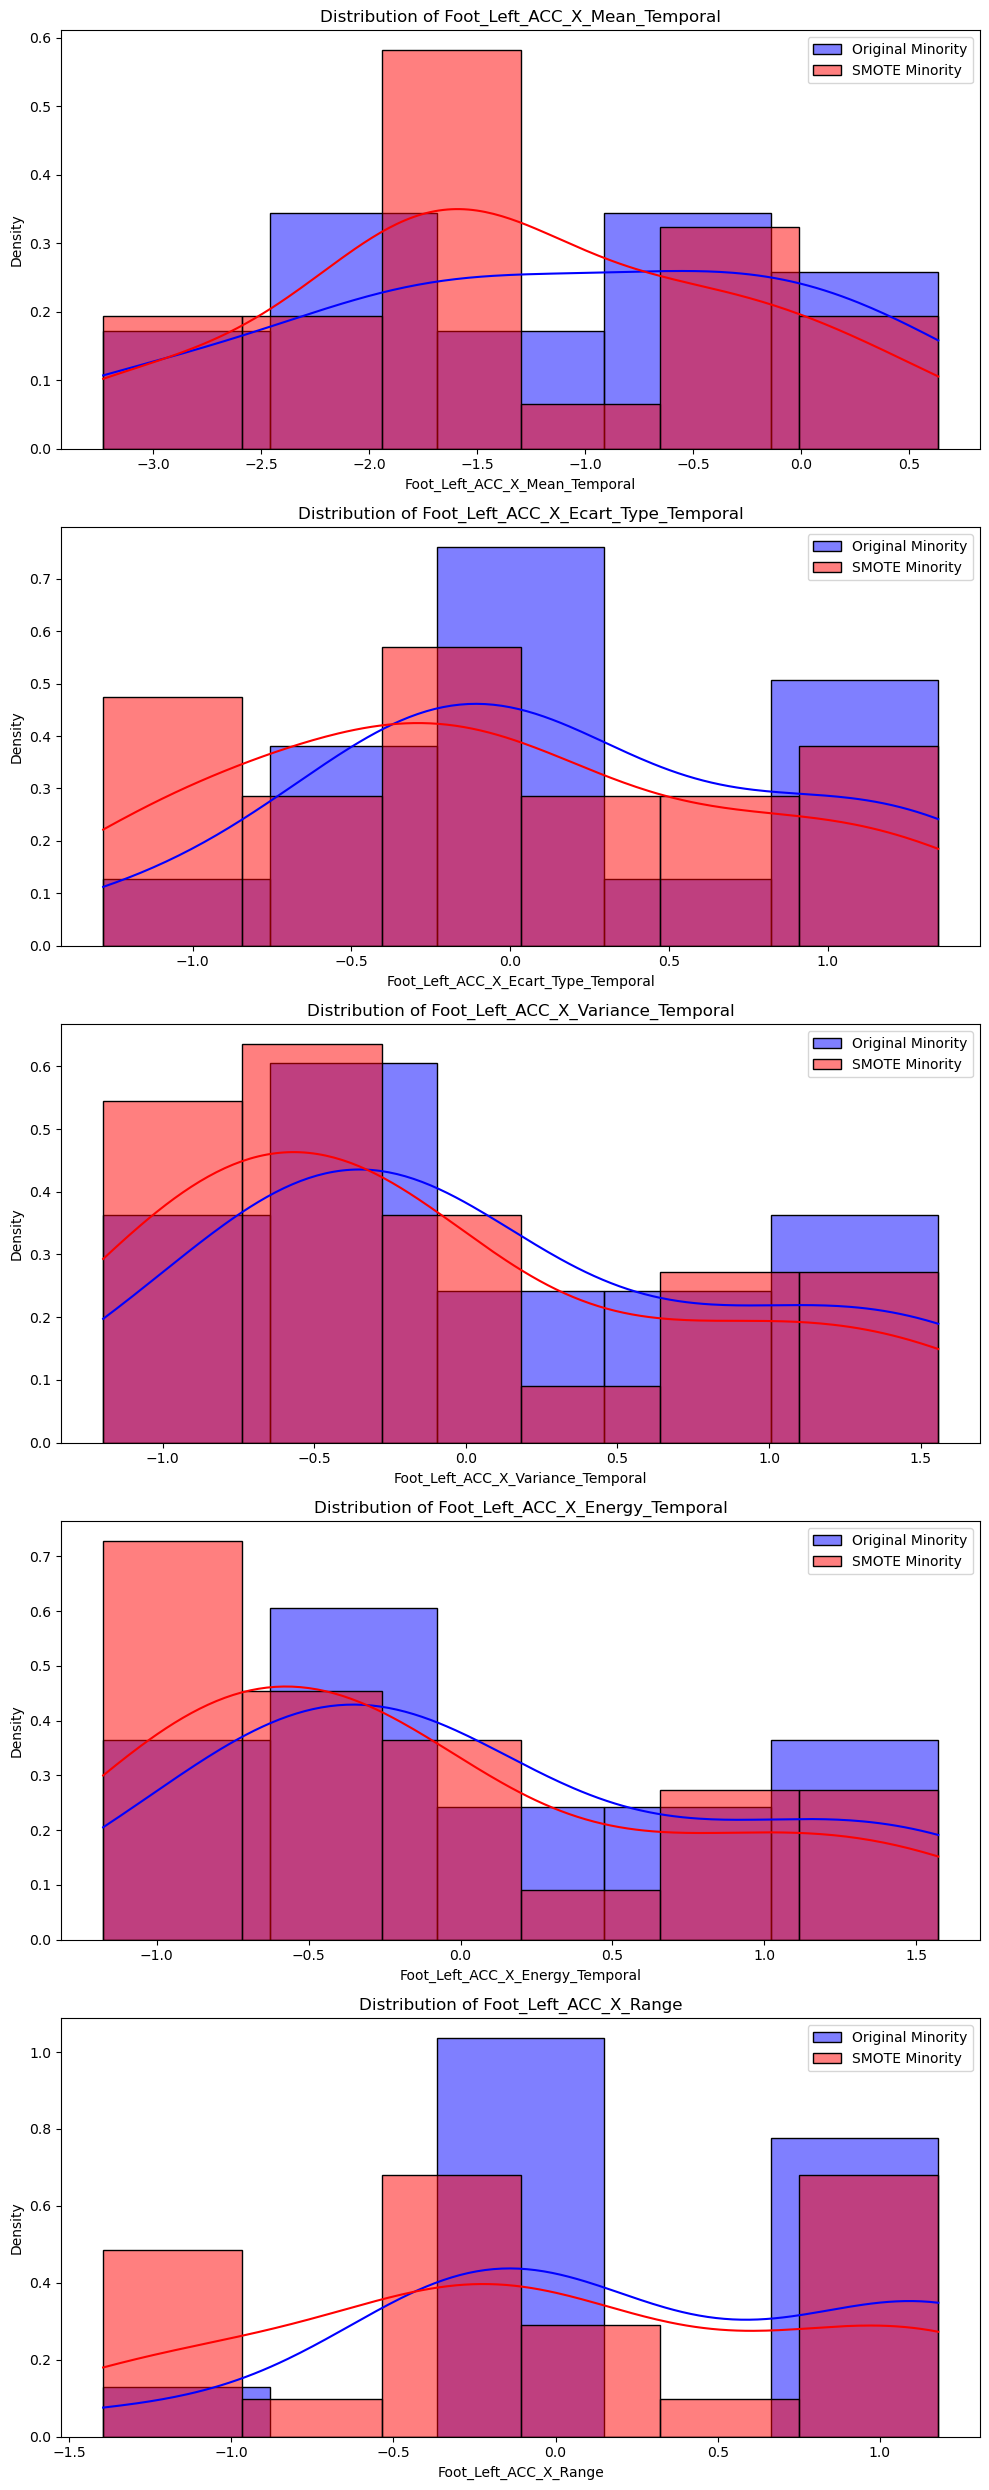

In [13]:
'''Visualisation de la classe minoritaire'''
# Identifier la classe minoritaire
minority_class = y_train.value_counts().idxmin()

# Filtrer les données de la classe minoritaire dans les données originales
X_minority_original = X_train[y_train == minority_class]

# Filtrer les données de la classe minoritaire dans les données SMOTE
# Supposons que X_smote_added et y_smote_added soient les données après SMOTE
X_minority_smote = X_resampled[y_resampled == minority_class]

# Sélection des 10 premières caractéristiques pour la visualisation
features_to_plot = X_train.columns[:5]

# Fonction pour tracer les distributions des caractéristiques
def plot_feature_distributions(df1, df2, feature_names, df1_label='Original Minority', df2_label='SMOTE Minority'):
    fig, axes = plt.subplots(nrows=len(feature_names), ncols=1, figsize=(10, 5 * len(feature_names)))
    for i, feature in enumerate(feature_names):
        ax = axes[i] if len(feature_names) > 1 else axes
        sns.histplot(df1[feature], color="blue", label=df1_label, kde=True, ax=ax, stat="density", common_norm=False)
        sns.histplot(df2[feature], color="red", label=df2_label, kde=True, ax=ax, stat="density", common_norm=False)
        ax.set_title(f'Distribution of {feature}')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Appeler la fonction de visualisation
plot_feature_distributions(X_minority_original, X_minority_smote, features_to_plot)

# VC pour le nombre de voisin optimal à utiliser dans Relief F

In [12]:
# Préparer ReliefF avec GridSearch pour trouver le meilleur nombre de voisins
param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}
relief = ReliefF()
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=relief, param_grid=param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)

c:\Users\antho\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\antho\anaconda3\lib\site-packages\pandas\core\indexes\base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi",

KeyError: 0

# Application du Relief F

In [ ]:

# Initialisation de ReliefF
relief = ReliefF(n_neighbors=20)  # Vous pouvez ajuster 'n_neighbors' selon la taille de votre jeu de données et les spécificités du problème

# Entraînement de ReliefF sur les données d'entraînement
relief.fit(X_train.to_numpy(), y_train.to_numpy())

# Obtention des scores de l'importance des caractéristiques
feature_scores = relief.feature_importances_

# Création d'un DataFrame pour mieux visualiser les scores des caractéristiques
feature_importance_df = pd.DataFrame(feature_scores, index=X_train.columns, columns=["Importance"])
feature_importance_df.sort_values("Importance", ascending=False, inplace=True)